In [1]:
'''
Credit goes to Mr. Giorgio for creating the very helpful modules used in this file.
'''

'\nCredit goes to Mr. Giorgio for creating the very helpful modules used in this file.\n'

### Imports and table functions

In [2]:
import sys, os
sys.path.append('/Users/meet/Desktop/Courses/Research/Chem/Code/QA/g_modules')
sys.path.append('/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules')
# Add the parent directory to the system path
sys.path.append('/Users/meet/Desktop/Courses/Research/Chem/Code/QA')

from pyscf import gto,scf, cc
import numpy as np
import pyscf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
from AP_class import APDFT_perturbator as AP
from alch_deriv import first_deriv_elec,DeltaV
%load_ext autoreload
%autoreload 2
from stat_funcs import *
from scipy.optimize import curve_fit
import numpy.fft as fft
from scipy.signal import find_peaks
from scipy.stats import pearsonr

In [3]:
def get_free_energy(mol_i, n):
    '''takes a molecule and the power of the free energy term and returns the free energy'''
    return -0.5*np.sum(mol_i.atom_charges()**n)

def new_mol(mol_i,n,l_i, l_f, left_right = None):
    '''Returns a new molecule, the converged object,
    total electronic energy and free energy of the new molecule
    at the l_i, l_f perturbation with n as the non linearity parameter.'''

    if left_right == 'L':
        '''if the H atom is on the left side of the molecule, only perturb the ones on the right'''
        mol = FcM_like(mol_i,fcs=[[1,2],[l_i,l_f]])

    else:
        mol = FcM_like(mol_i,fcs=[[0,1],[l_i,l_f]])

    mf_mol=scf.RKS(mol)
    mf_mol.xc="PBE0"
    mf_mol.verbose = 0
    mf_mol.scf(dm0=mf_mol.init_guess_by_1e())
    elec_energy = round(mf_mol.energy_elec()[0],3)

    return [mol, mf_mol, elec_energy, get_free_energy(mol,n)]

def d_Z_lambda(mol_i, mol_f,n,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    num = (1/n)* (Z_f**n - Z_i**n)
    den = ((Z_i**n) + lam*(Z_f**n - Z_i**n))**(1 - 1/n)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

def AG(mf,sites=[0,1]):
    grads=[]
    for site in sites:
        grads.append(first_deriv_elec(mf,DeltaV(mf.mol,[[site],[1]])))
    return np.array(grads)

def get_pred(mol_i,AG_i, n,e_i,l_i,l_f):
    '''Returns the linear Z and non linear Z prediction
    from mol_i using its alchemical grad and energy
    at specific perturbation l_i, l_f at the individual atoms

    Caution: l_i = l_f to increase and decrease nuclear charge by same amount in 2 atoms.
    Observe the negative sign.
    '''

    mol = FcM_like(mol_i,fcs=[-l_i,l_f])
    return np.round([e_i + np.dot(Z_diff(mol_i,mol), AG_i),e_i + np.dot(d_Z_lambda(mol_i,mol,n,0), AG_i)],3)

def gen_data(mol,AG,n,e_mol,l_i, l_f):
    l_pre = []
    nl_pre = []
    for i in np.linspace(l_i,l_f, steps + 1):
        pre = get_pred(mol, AG,n, e_mol, i,i)
        l_pre.append(pre[0])
        nl_pre.append(pre[1])
    return np.array(l_pre), np.array(nl_pre)

In [4]:
'''wrapper function for generating DFT data'''
def get_symmetric_change_data(min_lam,max_lam, gen=False):
    if gen:
        frac_energies = []
        free_energies = []
        i = min_lam
        while round(i,3) <= max_lam:
            mol_props = new_mol(NN,7/3, -i,i)
            e_mol = mol_props[2]
            free_e = mol_props[3]
            frac_energies.append(e_mol)
            free_energies.append(free_e)
            i  += 0.1
        frac_energies = np.array(frac_energies)
        free_energies = np.array(free_energies)
        np.savetxt(f"data/dft_0_to_{max_lam}.csv",[frac_energies,free_energies])

    return np.loadtxt(f'data/dft_0_to_{max_lam}.csv')

def get_asymmetric_change_data(min_lam,max_lam, gen=False):
    if gen:
        R_NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}; H 0 0 {d+s}",unit="Bohr",charge=1,basis='unc-ccpvdz')
        L_NN = gto.M(atom= f"H 0 0 {-s}; N 0 0 0; N 0 0 {d}",unit="Bohr",charge=1,basis='unc-ccpvdz')
        # can protonate in the nearby atom and the far atom
        R_atom_p = []
        L_atom_p = []
        i = min_lam

        while round(i,3) <= max_lam:
            mol_props_R = new_mol(R_NN,7/3, -i,i,left_right='R')
            e_mol_R = mol_props_R[2]
            R_atom_p.append(e_mol_R)

            mol_props_L = new_mol(L_NN,7/3, -i,i,left_right='L')
            e_mol_L = mol_props_L[2]
            L_atom_p.append(e_mol_L)
            i  += 0.1

        np.savetxt(f"data/prot_0_to_{max_lam}.csv",[R_atom_p,L_atom_p])

    return np.loadtxt(f'data/prot_0_to_{max_lam}.csv')

### Defining my molecules

In [5]:
# uncontracted cc-pvdz
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
mf_NN, e_NN = new_mol(NN, 7/3, 0,0)[1],new_mol(NN,7/3, 0,0)[2]
CO, mf_CO, e_CO = new_mol(NN, 7/3, -1,1)[:3]
BF, mf_BF, e_BF = new_mol(NN, 7/3, -2,2) [:3]

e_BeNe, e_LiNA,e_HeMg, e_HAl, e_Si = new_mol(NN,7/3,-3,3)[2],new_mol(NN,7/3,-4,4)[2], new_mol(NN,7/3,-5,5)[2],\
                                    new_mol(NN,7/3,-6,6)[2],new_mol(NN,7/3,-7,7)[2]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


In [6]:
'''Data for max_lambda = 5 and = 7 is stored in data folder'''
## Calculating actual fractional charge energies
max_lam = 7
gen = False
data = get_symmetric_change_data(0,max_lam,gen)
frac_energies,free_energies =  data[0], data[1]

'''getting / generating data for protonation'''
s = 0.94 # 0.5 angstroms or 0.94 Bohr.
gen = False
data = get_asymmetric_change_data(0,max_lam, gen)
R_P,L_P = data[0],data[1]

FileNotFoundError: data/dft_0_to_7.csv not found.

### Gradients between NN and CO and BF

In [ ]:
# Evaluating the linearized energy gradient at lambda = 0
AG_NN = AG(mf_NN) # the alchemical gradient i.e. d_E / d_Z_I for where Z_I are N atoms
AG_CO = AG(mf_CO)
AG_BF = AG(mf_BF)

In [ ]:
'''Preparing prediction data for plotting for symmetrical alchemical changes for n = 7/3'''
steps = max_lam * 10 # ensures a 0.1 step size
pre_NN_l, pre_NN_nl = gen_data(NN,AG_NN,7/3,e_NN,0, max_lam)
pre_CO_l, pre_CO_nl = gen_data(CO,AG_CO,7/3,e_CO,-1, max_lam -1)
pre_BF_l, pre_BF_nl = gen_data(BF,AG_BF,7/3,e_BF,-2, max_lam -2)
prediction_7_3 = np.array([pre_NN_nl, pre_CO_nl, pre_BF_nl])

In [ ]:
'''
Preparing prediction data for plotting for
symmetrical alchemical changes for n in (0.5, 3) in steps of 0.1'''
'''
Structure of predictions_n:
    predictions_n = [...,[pre_NN_nl_n, pre_CO_nl_n, pre_BF_nl_n],...]
    pre_NN_nl_n = non-linear Z prediction over all lambda at n from NN
'''
predictions_n = []
for n in np.linspace(0.5,5,46):
    pre_NN_nl_n = gen_data(NN,AG_NN,n,e_NN,0, max_lam)[1]
    pre_CO_nl_n = gen_data(CO,AG_CO,n,e_CO,-1, max_lam -1)[1]
    pre_BF_nl_n = gen_data(BF,AG_BF,n,e_BF,-2, max_lam -2)[1]
    predictions_n.append(np.array([pre_NN_nl_n, pre_CO_nl_n, pre_BF_nl_n]))
predictions_n = np.array(predictions_n)
prediction_2 = predictions_n[15]

In [ ]:
# fitting errors only upto a certain lambda
max_lam_err = 7
# store difference between numpy arrays of size (51,) and (3,71) in a numpy array of size (3,51) in one line
prediction = prediction_2
pre_2_restricted = np.array([ prediction[i][:max_lam_err*10 + 1] for i in range(3)])
dft_pred_restricted = np.array([ frac_energies[:max_lam_err*10 + 1] for i in range(3)])
'''Defining the total x_axis'''
x_axis = np.linspace(0,max_lam,steps + 1)

'''Defining the new x axis for fitting errors'''
x_axis_err = x_axis[:max_lam_err*10 + 1]

In [ ]:
'''Fitting away 2nd order errors'''
quad_err = dft_pred_restricted - pre_2_restricted
# quad_err = dft_pred_restricted - prediction_7_3[:,:max_lam_err*10 + 1]
err_fits = []
for i in range(3):
    popt_, pcov_ = curve_fit(quad_fit, x_axis_err, quad_err[i],absolute_sigma=True,maxfev=100000)
    fitted_err_ = np.array(quad_fit(x_axis, *popt_))
    err_fits.append(fitted_err_)

quad_adjusted_prediction = prediction + np.array(err_fits)
quad_adjusted_pre_restriced = np.array([quad_adjusted_prediction[i][:max_lam_err*10 + 1] for i in range(3)])

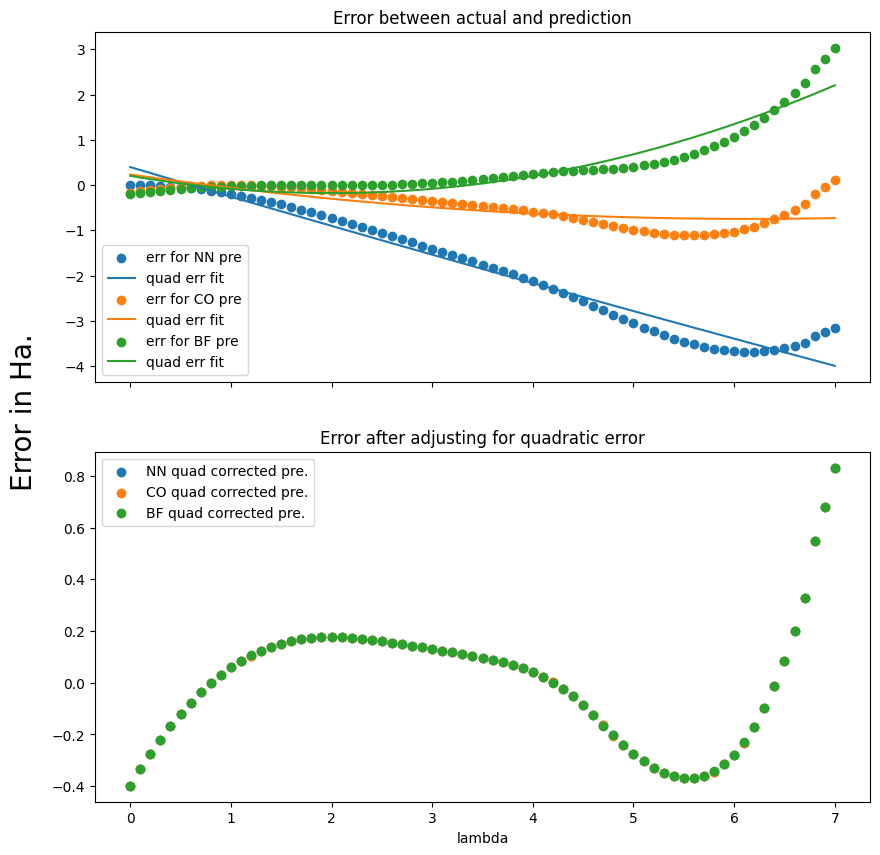

In [ ]:
# plotting error between actual and prediction
comps = ['NN','CO','BF']
def plot_quad_errors():
    # SHOULD PLOT BOTH INITIAL ERROR AND ERROR AFTER FITTING AWAY QUADRATIC ERRORS
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    for i in range(3):
        # plt.scatter(x_axis, quart_err[i], label = 'actual err')
        # plt.scatter(x_axis_err,(dft_pred_restricted-quad_adjusted_pre_restriced)[i], label = 'quad adjusted err')
        ax[0].scatter(x_axis, frac_energies - prediction[i], label = f'err for {comps[i]} pre')
        ax[0].plot(x_axis, err_fits[i],label = 'quad err fit')
        # ax[1].scatter(x_axis, quart_err[i], label = 'actual err')
        # ax[1].scatter(x_axis_err,(dft_pred_restricted-quad_adjusted_pre_restriced)[i], label = i)
        ax[1].scatter(x_axis, frac_energies - quad_adjusted_prediction[i], label = f'{comps[i]} quad corrected pre.')
    ax[0].legend()
    # ax[0].set_ylabel('dft - prediction in Ha.')
    ax[0].set_title('Error between actual and prediction')
    ax[1].set_title('Error after adjusting for quadratic error')
    ax[1].set_xlabel('lambda')
    ax[1].legend()
    fig.text(0.04, 0.5, 'Error in Ha.', va='center', rotation='vertical',size=20)
plot_quad_errors()

In [ ]:
'''Fititng quarttic error'''
quart_err = dft_pred_restricted - quad_adjusted_pre_restriced
fits = []
for i in range(3):
    popt_, pcov_ = curve_fit(quart_fit, x_axis_err, quart_err[i],absolute_sigma=True)
    fitted_err_ = np.array(quart_fit(x_axis, *popt_))
    fits.append(fitted_err_)

quart_adjusted_prediction = quad_adjusted_prediction +np.array(fits)
quart_adjusted_pre_restriced = np.array([quart_adjusted_prediction[i][:max_lam_err*10 + 1] for i in range(3)])

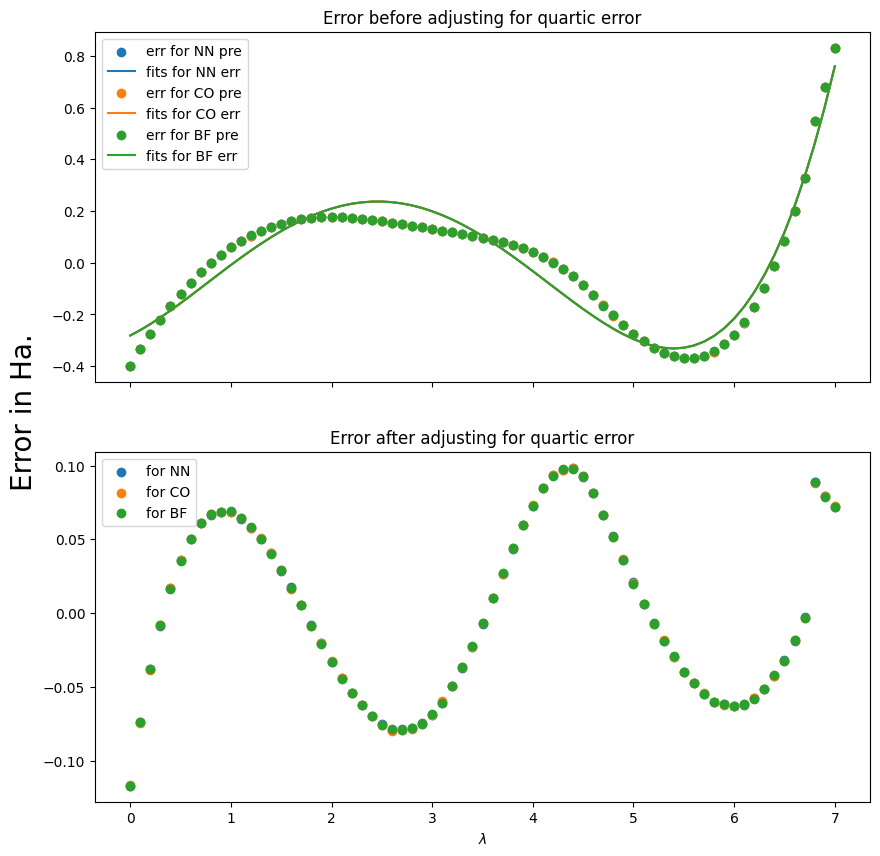

In [ ]:
def plot_quartic_errors():
    # plotting error between actual and quad adjusted
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    for i in range(3):
        # plt.scatter(x_axis, quart_err[i], label = 'actual err')
        # plt.scatter(x_axis_err,(dft_pred_restricted-quart_adjusted_pre_restriced)[i], label = 'quart adjusted err')
        ax[0].scatter(x_axis, frac_energies - quad_adjusted_prediction[i], label = f'err for {comps[i]} pre')
        ax[0].plot(x_axis, quart_adjusted_prediction[i] - quad_adjusted_prediction[i], label = f'fits for {comps[i]} err')
        ax[1].scatter(x_axis, frac_energies - quart_adjusted_prediction[i], label = f'for {comps[i]}')
    ax[0].set_title('Error before adjusting for quartic error')
    ax[1].set_title('Error after adjusting for quartic error')
    ax[0].legend()
    ax[1].legend()
    ax[1].set_xlabel(r'$\lambda$')
    fig.text(0.04, 0.5, 'Error in Ha.', va='center', rotation='vertical',size=20)
plot_quartic_errors()

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_2970/3928590083.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['NN','CO','BF','BeNe','LiNa','HeMg','HAl','Si'])


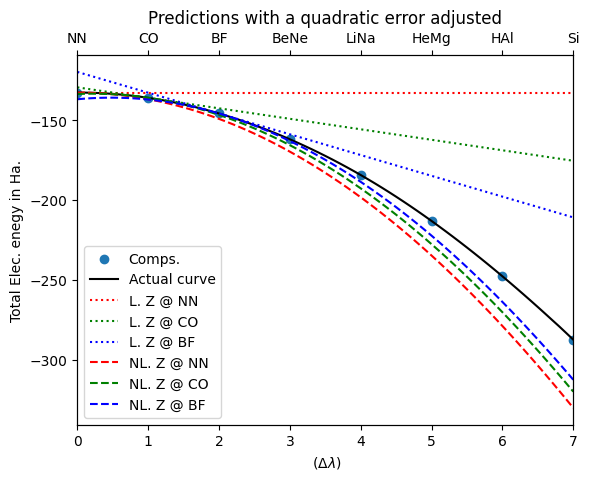

In [ ]:
'''Plotting graph with linear and non-linear grads for symmetrical alchemical changes'''
# call l_nl_plot() from plots.py
l_vals = np.array([np.array(x) for x in [pre_NN_l,pre_CO_l,pre_BF_l]])
l_keys = ['L. Z @ NN', 'L. Z @ CO','L. Z @ BF']
nl_keys = ['NL. Z @ NN','NL. Z @ CO','NL. Z @ BF']

l_lines = dict(zip(l_keys, l_vals))
nl_lines = dict(zip(nl_keys,prediction_7_3))
all_lines = {**l_lines, **nl_lines}

format = ['r:','g:', 'b:','r--','g--', 'b--']

# figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots()
ax.scatter([0,1,2,3,4,5,6,7],[e_NN, e_CO, e_BF, e_BeNe, e_LiNA, e_HeMg, e_HAl, e_Si],label='Comps.')
ax.plot(x_axis,np.array(frac_energies),'black',label='Actual curve')
# ax.plot(x_axis,np.array(R_P),'brown',label='R. protonated curve')
# ax.plot(x_axis,np.array(L_P),'grey',label='L. protonated curve')

i = 0
for line in all_lines:
    # plt.scatter(np.linspace(0,2,len(lines[line])),lines[line],label=line)
    plt.plot(x_axis,all_lines[line],format[i],label=line)
    i +=1
ax.legend()
ax.set_ylabel('Total Elec. enegy in Ha.')
ax.set_xlabel(r' ($\Delta \lambda$)')
ax.set_xlim(0,7)
ax.set_title('Predictions with a quadratic error adjusted')

# add another x axis in plot
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(['NN','CO','BF','BeNe','LiNa','HeMg','HAl','Si'])
plt.savefig('data/figs/main_prediction_plot.png')

/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:76: RuntimeWarning: overflow encountered in exp
  return A*np.exp((freq+offset)*n) + base


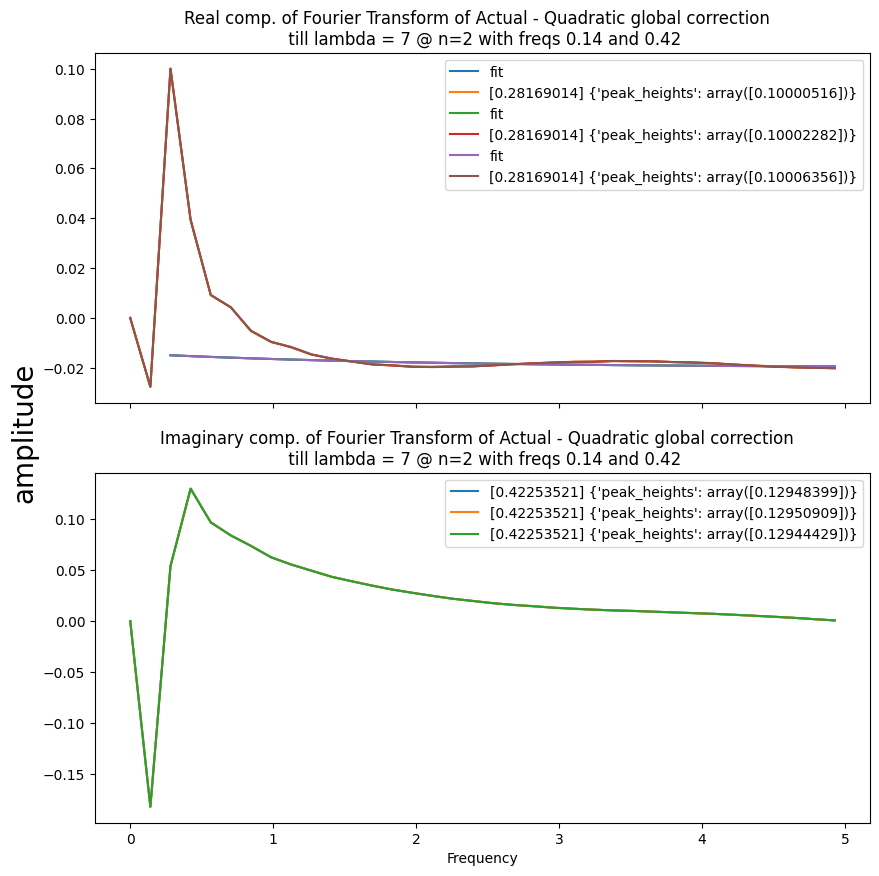

In [ ]:
def FT():
    err = dft_pred_restricted - quad_adjusted_pre_restriced
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    for i in range(3):
        data = err[i]
        N = len(data)  # Number of data points
        normalization = 2 / N
        fft_data = normalization * np.fft.fft(data)
        # Compute the frequencies
        frequencies = np.fft.fftfreq(N, d = 0.1)

        # Shift the frequencies to have 0 at the center
        frequencies = np.fft.fftshift(frequencies)[N//2:]
        fft_data = np.fft.fftshift(fft_data)[N//2:]

        # finding peaks for feeding curve-fit parameters
        peaks_r = find_peaks(np.real(fft_data), height = 0.05)
        peaks_i = find_peaks(np.imag(fft_data), height = (0.10,0.15))

        # fitting the fourier transforms
        # print(np.real(fft_data)[peaks_r[0][0]:])
        popt_r, pcov_r = curve_fit(exp, frequencies[peaks_r[0][0]:], np.real(fft_data)[peaks_r[0][0]:],\
            p0 = [0.02,-frequencies[peaks_r[0][0]], -0.5 , -0.02])
        real_fit = exp(frequencies[peaks_r[0][0]:], *[0.005,-0.28,-0.5,-0.02])
        # Plot the Fourier transform
        ax[0].plot(frequencies[peaks_r[0][0]:], real_fit,  label=f'fit')
        ax[0].plot(frequencies, np.real(fft_data),  label=f'{frequencies[peaks_r[0]]} {peaks_r[1]}')
        ax[1].plot(frequencies, np.imag(fft_data), label=f'{frequencies[peaks_i[0]]} {peaks_i[1]}')

    ax[1].set_xlabel('Frequency')
    ax[1].set_title('Imaginary comp. of Fourier Transform of Actual - Quadratic global correction  \n till lambda = 7 @ n=2 with freqs 0.14 and 0.42')
    ax[1].legend()
    ax[0].set_title('Real comp. of Fourier Transform of Actual - Quadratic global correction  \n till lambda = 7 @ n=2 with freqs 0.14 and 0.42')
    ax[0].legend()
    fig.text(0.04, 0.5, 'amplitude', va='center', rotation='vertical',size=20)

FT()

## lambda exponentiated fourier approximations

In [ ]:
comps = ['NN', 'CO','BF']
# fitting the eror after adjusting quadratic error.
err_to_fit = dft_pred_restricted - quad_adjusted_pre_restriced

def get_fourier_pred(N):
    '''Gets the lambda dependent fourier prediction upto Nth order for the error after adjusting the quadratic error.'''
    fits = []
    funcs = [ff1, ff2, ff3, ff4,ff5]
    base = (3.977507e-02,  0.28, -1.20482758e+01,  1.16835373e-01)
            # 5.40220558e-03)
    for i in range(1,N):
        base += (3.977507e-02,  0.28, -1.20482758e+01,  1.16835373e-01)
            # 5.40220558e-03)
    popts = []
    for j in range(3):
        popt, pcov = curve_fit(funcs[N-1], x_axis_err, err_to_fit[j],p0=base,absolute_sigma=True,maxfev=10000000)
        fits.append(funcs[N-1](x_axis,*popt))
        # print(f'b is {popt[0]} for {comps[j]}')
        popts.append(np.array(popt))
    return quad_adjusted_prediction + np.array(fits), np.array(popts)

0 1
1 2
2 3


/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:64: RuntimeWarning: overflow encountered in exp
  return A*np.exp(lam*exp) * np.sin(lam*f + p) + A2*np.exp(lam*exp2) * np.sin(lam*f2 + p2) + A3*np.exp(lam*exp3) * np.sin(lam*f3 + p3)
/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:67: RuntimeWarning: overflow encountered in exp
  return A*np.exp(lam*exp) * np.sin(lam*f + p) + A2*np.exp(lam*exp2) * np.sin(lam*f2 + p2) + A3*np.exp(lam*exp3) * np.sin(lam*f3 + p3) + A4*np.exp(lam*exp4) * np.sin(lam*f4 + p4)


3 4


/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:70: RuntimeWarning: overflow encountered in exp
  return A*np.exp(lam*exp) * np.sin(lam*f + p) + A2*np.exp(lam*exp2) * np.sin(lam*f2 + p2) + A3*np.exp(lam*exp3) * np.sin(lam*f3 + p3) + A4*np.exp(lam*exp4) * np.sin(lam*f4 + p4) + A5*np.exp(lam*exp5) * np.sin(lam*f5 + p5)
/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:70: RuntimeWarning: overflow encountered in multiply
  return A*np.exp(lam*exp) * np.sin(lam*f + p) + A2*np.exp(lam*exp2) * np.sin(lam*f2 + p2) + A3*np.exp(lam*exp3) * np.sin(lam*f3 + p3) + A4*np.exp(lam*exp4) * np.sin(lam*f4 + p4) + A5*np.exp(lam*exp5) * np.sin(lam*f5 + p5)
/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:70: RuntimeWarning: invalid value encountered in add
  return A*np.exp(lam*exp) * np.sin(lam*f + p) + A2*np.exp(lam*exp2) * np.sin(lam*f2 + p2) + A3*np.exp(lam*exp3) * np.sin(lam*f3 + p3) + A4*np.exp(lam*exp4) * np.sin(lam*f4 + p4)

4 5


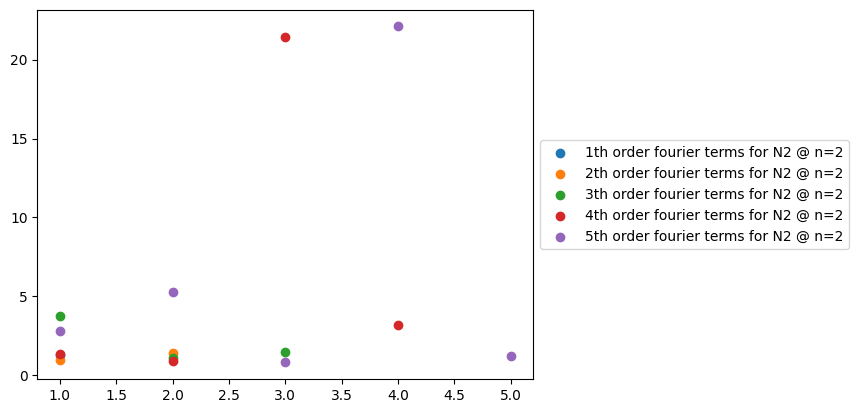

In [ ]:
for i in range(5):
    popts = get_fourier_pred(i+1)[1]
    plt.scatter(np.linspace(1,i+1,i+1),np.abs(popts[0][1::4]), label = f'{i+1}th order fourier terms for N2 @ n=2')
    # print(f'popt for {i+1}th order is {popts}')
    # get every 5th value of the popt and plot it against the order in one line
    # plot each point in popts[0][1::5] as scatter plot with individual labels
    print(i,len(popts[0][1::4]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# put legend outside the plot

Text(0.5, 1.0, 'Fitting quad fit error')

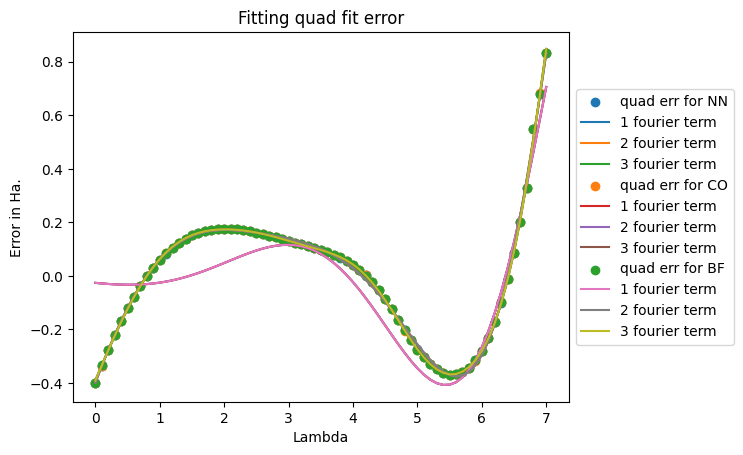

In [ ]:
# to check whether the fits accurately model the error
for i in range(3):
    plt.scatter(x_axis, frac_energies - quad_adjusted_prediction[i], label = f'quad err for {comps[i]}')
    plt.plot(x_axis, (get_fourier_pred(1)[0]-quad_adjusted_prediction)[i], label = '1 fourier term')
    plt.plot(x_axis, (get_fourier_pred(2)[0]-quad_adjusted_prediction)[i], label = '2 fourier term')
    plt.plot(x_axis, (get_fourier_pred(3)[0]-quad_adjusted_prediction)[i], label = '3 fourier term')
    # plt.plot(x_axis, ff(x_axis, *[ 2.19714862e-02,  1.70264763e+00 ,-11.10,  1.07301660e+00,7.97399174e-03]),label='Real')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Lambda')
plt.ylabel('Error in Ha.')
plt.title('Fitting quad fit error')
# get legend out of the plot

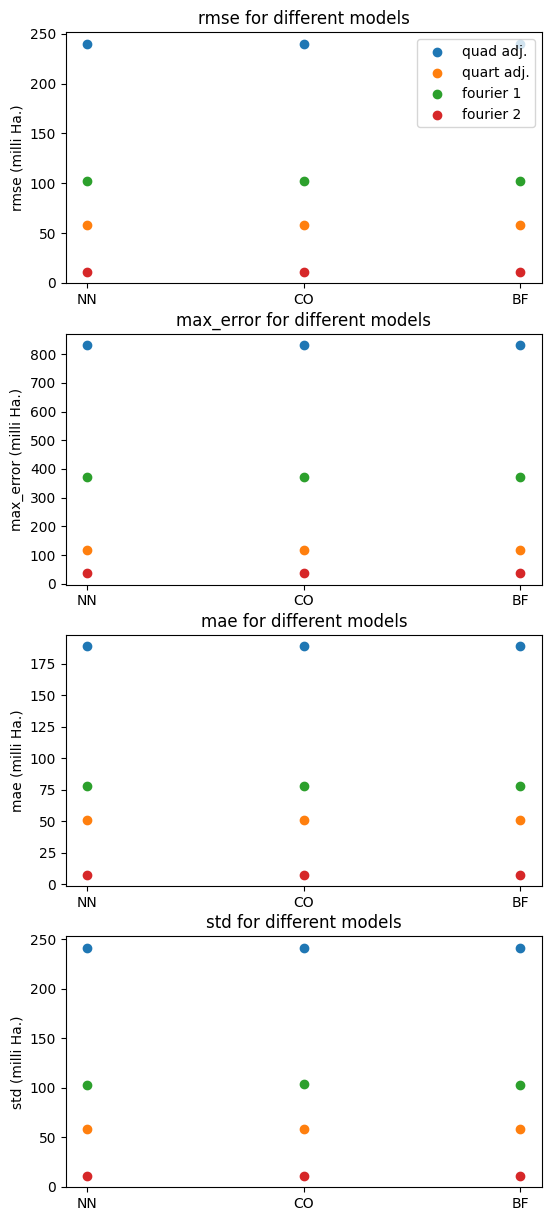

In [ ]:
'''PLotting all the errors for the different models'''
comps = ['NN', 'CO', 'BF']
error_funcs = [rmse, max_error, mae, std]
models = [quad_adjusted_prediction, \
    quart_adjusted_prediction, get_fourier_pred(1)[0], get_fourier_pred(2)[0]]
labels = ['quad adj.', 'quart adj.', 'fourier 1', 'fourier 2']
all_errors = []
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4,1, figsize = (15,15))
axes = [ax1, ax2, ax3, ax4]
for f in range(len(error_funcs)):
    for model in range(len(models)):
        err = []
        for i in range(3):
            # if labels[model] not in ['n = 2 adjusted quad. err','fourier 1', 'fourier 2']:
            err.append(error_funcs[f](frac_energies, models[model][i]))
            # else:
            #     err.append(error_funcs[f](frac_energies[:61], models[model][i]))

        # changing to milli hartree
        err = np.array(err)*1000
        axes[f].scatter(comps,err, label=f'{labels[model]}')
        axes[f].set_ylabel(f'{error_funcs[f].__name__} (milli Ha.)')
        axes[f].set_title(f'{error_funcs[f].__name__} for different models')
        # shift legend outside of plot
        box = axes[f].get_position()
        axes[f].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        axes[0].legend()
        # axes[f].legend()
plt.savefig('data/figs/all_models_err.png')
# fig.suptitle(r'Errors for different n where $Z(\lambda) = (Z_i^n + \lambda (Z_f^n-Z_i^n))^{\frac{1}{n}}$', fontsize=25)

/Users/meet/Desktop/Courses/Research/Chem/Code/QA/m_modules/stat_funcs.py:64: RuntimeWarning: overflow encountered in exp
  return A*np.exp(lam*exp) * np.sin(lam*f + p) + A2*np.exp(lam*exp2) * np.sin(lam*f2 + p2) + A3*np.exp(lam*exp3) * np.sin(lam*f3 + p3)


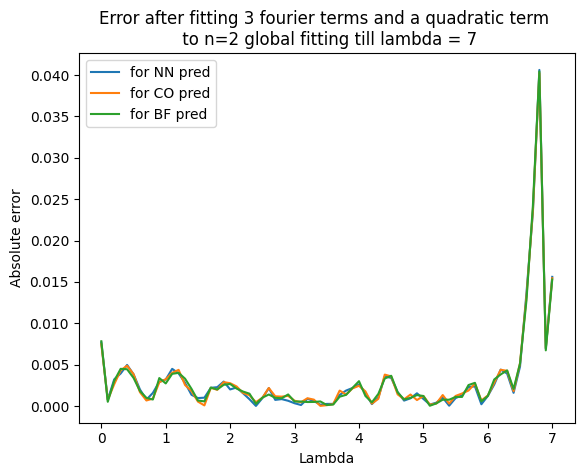

In [ ]:
x_axis = np.linspace(0,max_lam,steps + 1)
err = np.abs(frac_energies - get_fourier_pred(3)[0])
for i in range(3):
    plt.plot(x_axis,err[i],label=f'for {comps[i]} pred')
plt.xlabel('Lambda')
plt.ylabel('Absolute error')
plt.title('Error after fitting 3 fourier terms and a quadratic term \n to n=2 global fitting till lambda = 7')
plt.legend()
plt.savefig('data/figs/3_fourier_terms.png')
# create numpy array of same value
# print(f'MAE errors for 3 fourier terms {mae(frac_energies,get_fourier_pred(3)[0]),mae(frac_energies,get_fourier_pred(3)[1]),mae(frac_energies,get_fourier_pred(3)[2])}')

In [ ]:
# testing Anatole's conjecture that systems with max symmetries have the largest electronic energies

### Calculating and plotting interaction energies / measures of models

$$\Delta_1 = E^{int}_{ele} = E^{Tot}_{ele} - \sum_{I} E^{free}_{I, ele}$$
$$\Delta_2 = E^{Tot}_{ele} / \sum_{I} E^{free}_{I, ele}$$
$$\Delta_3 = E^{Prot.}_{ele} - E^{Tot.}_{ele} \text{ for left and right}$$ 
this can be done for all $n$, where $E^{free}_{I, ele} \approx -\dfrac{1}{2}Z_I^n$

In [ ]:
# copy paste appropriate function from measures.py and call it here.